LINEAR REGRESSION IMPLEMENTATION
Features shape: (20640, 8)
Target shape: (20640,)
Selected features shape: (16512, 8)

Linear Regression Results:
------------------------------
Training RMSE: 0.7197
Testing RMSE: 0.7456
Training R²: 0.6126
Testing R²: 0.5758
Testing MAE: 0.5332
CV RMSE: 0.7205 (+/- 0.0206)

Ridge Regression Results:
------------------------------
Training RMSE: 0.7197
Testing RMSE: 0.7453
Training R²: 0.6125
Testing R²: 0.5761
Testing MAE: 0.5331
CV RMSE: 0.7205 (+/- 0.0205)

Lasso Regression Results:
------------------------------
Training RMSE: 0.7197
Testing RMSE: 0.7446
Training R²: 0.6125
Testing R²: 0.5769
Testing MAE: 0.5331
CV RMSE: 0.7205 (+/- 0.0203)


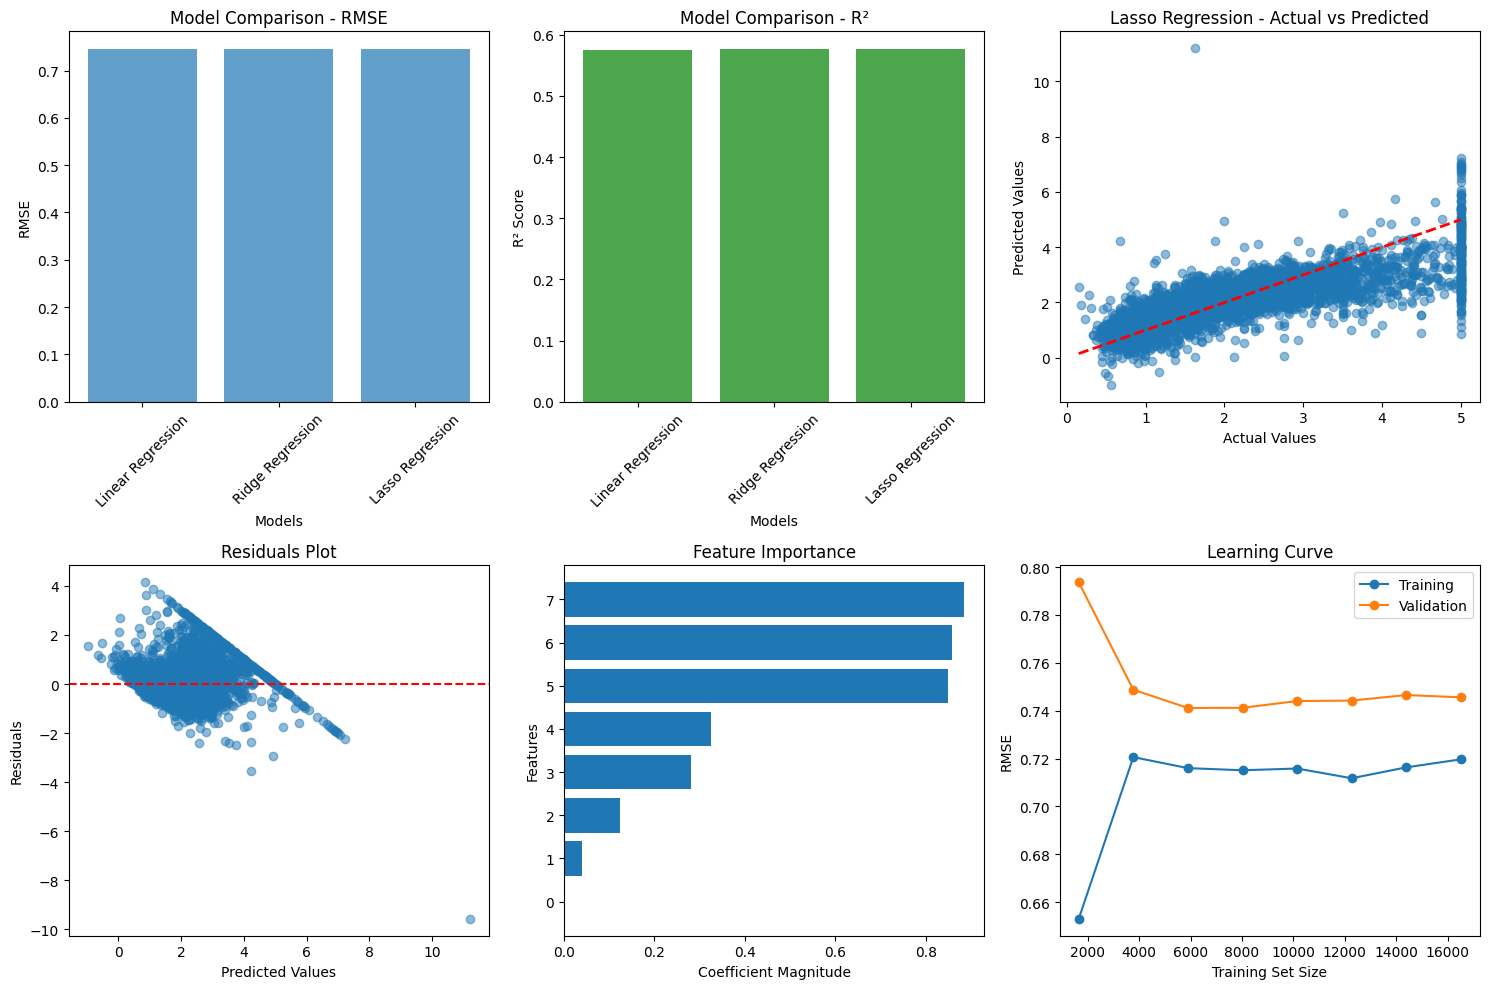


Best Model: Lasso Regression
Best RMSE: 0.7446
Best R²: 0.5769


In [10]:
# Notebook: 03_linear_regression.ipynb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.datasets import fetch_california_housing

print("LINEAR REGRESSION IMPLEMENTATION")
print("="*50)

# Load a reliable built-in regression dataset (no external CSVs required)
housing = fetch_california_housing(as_frame=True)
df = housing.frame

# Prepare features and target
X = df.drop('MedHouseVal', axis=1)
y = df['MedHouseVal']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature selection (keep all features if fewer than k)
k = min(20, X_train_scaled.shape[1])
selector = SelectKBest(score_func=f_regression, k=k)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

print(f"Selected features shape: {X_train_selected.shape}")

# Model Implementation
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=10.0),
    'Lasso Regression': Lasso(alpha=0.001, max_iter=10000)
}

results = {}

for name, model in models.items():
    print(f"\n{name} Results:")
    print("-" * 30)
    
    # Train the model
    model.fit(X_train_selected, y_train)
    
    # Predictions
    y_pred_train = model.predict(X_train_selected)
    y_pred_test = model.predict(X_test_selected)
    
    # Evaluation metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    
    print(f"Training RMSE: {train_rmse:.4f}")
    print(f"Testing RMSE: {test_rmse:.4f}")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Testing R²: {test_r2:.4f}")
    print(f"Testing MAE: {test_mae:.4f}")
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_selected, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores)
    print(f"CV RMSE: {cv_rmse.mean():.4f} (+/- {cv_rmse.std() * 2:.4f})")
    
    results[name] = {
        'model': model,
        'test_rmse': test_rmse,
        'test_r2': test_r2,
        'predictions': y_pred_test
    }

# Visualization
plt.figure(figsize=(15, 10))

# 1. Model comparison
plt.subplot(2, 3, 1)
model_names = list(results.keys())
rmse_scores = [results[name]['test_rmse'] for name in model_names]
r2_scores = [results[name]['test_r2'] for name in model_names]

x_pos = np.arange(len(model_names))
plt.bar(x_pos, rmse_scores, alpha=0.7)
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('Model Comparison - RMSE')
plt.xticks(x_pos, model_names, rotation=45)

# 2. R² comparison
plt.subplot(2, 3, 2)
plt.bar(x_pos, r2_scores, alpha=0.7, color='green')
plt.xlabel('Models')
plt.ylabel('R² Score')
plt.title('Model Comparison - R²')
plt.xticks(x_pos, model_names, rotation=45)

# 3. Actual vs Predicted (best model)
best_model_name = min(results.keys(), key=lambda x: results[x]['test_rmse'])
best_predictions = results[best_model_name]['predictions']

plt.subplot(2, 3, 3)
plt.scatter(y_test, best_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'{best_model_name} - Actual vs Predicted')

# 4. Residuals plot
plt.subplot(2, 3, 4)
residuals = y_test - best_predictions
plt.scatter(best_predictions, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')

# 5. Feature importance (for regularized models)
if best_model_name in ['Ridge Regression', 'Lasso Regression']:
    plt.subplot(2, 3, 5)
    feature_importance = abs(results[best_model_name]['model'].coef_)
    feature_names = [f'Feature_{i}' for i in range(len(feature_importance))]
    top_features_idx = np.argsort(feature_importance)[-len(feature_importance):]
    plt.barh(range(len(top_features_idx)), feature_importance[top_features_idx])
    plt.xlabel('Coefficient Magnitude')
    plt.ylabel('Features')
    plt.title('Feature Importance')

# 6. Learning curve (simple)
plt.subplot(2, 3, 6)
train_sizes = np.linspace(0.1, 1.0, 8)
train_rmse_scores = []
val_rmse_scores = []

for train_size in train_sizes:
    sample_size = int(train_size * len(X_train_selected))
    X_sample = X_train_selected[:sample_size]
    y_sample = y_train.iloc[:sample_size]
    temp_model = LinearRegression()
    temp_model.fit(X_sample, y_sample)
    train_pred = temp_model.predict(X_sample)
    val_pred = temp_model.predict(X_test_selected)
    train_rmse_scores.append(np.sqrt(mean_squared_error(y_sample, train_pred)))
    val_rmse_scores.append(np.sqrt(mean_squared_error(y_test, val_pred)))

plt.plot(train_sizes * len(X_train_selected), train_rmse_scores, 'o-', label='Training')
plt.plot(train_sizes * len(X_train_selected), val_rmse_scores, 'o-', label='Validation')
plt.xlabel('Training Set Size')
plt.ylabel('RMSE')
plt.title('Learning Curve')
plt.legend()

plt.tight_layout()
plt.show()

print(f"\nBest Model: {best_model_name}")
print(f"Best RMSE: {results[best_model_name]['test_rmse']:.4f}")
print(f"Best R²: {results[best_model_name]['test_r2']:.4f}")